In [4]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [2]:
pars = (;r = 0.11, # interest rate
    w = 0.015, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 15000.0) # upper bound of capital grid

(r = 0.11, w = 0.015, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 15000.0)

In [5]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard(v, policy, Π, Agrid, Zgrid, tuple)
    (; β, na, nz, how_iter) = tuple
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV(Agrid, exp_val)
            for i in 1:na
                obj(ap) = (utility(resources(Agrid, Zgrid, i, j, pars) - ap, pars) + β * interp_e_val(ap))
                v[i,j] = obj(policy[i,j])
            end
        end
    end
    return v
end        

howard (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 100, Error: 5.380467492759879e-6
--------------------
Converged in 126 iterations
--------------------
 13.619604 seconds (16.63 M allocations: 1.164 GiB, 2.90% gc time, 88.66% compilation time: <1% of which was recompilation)


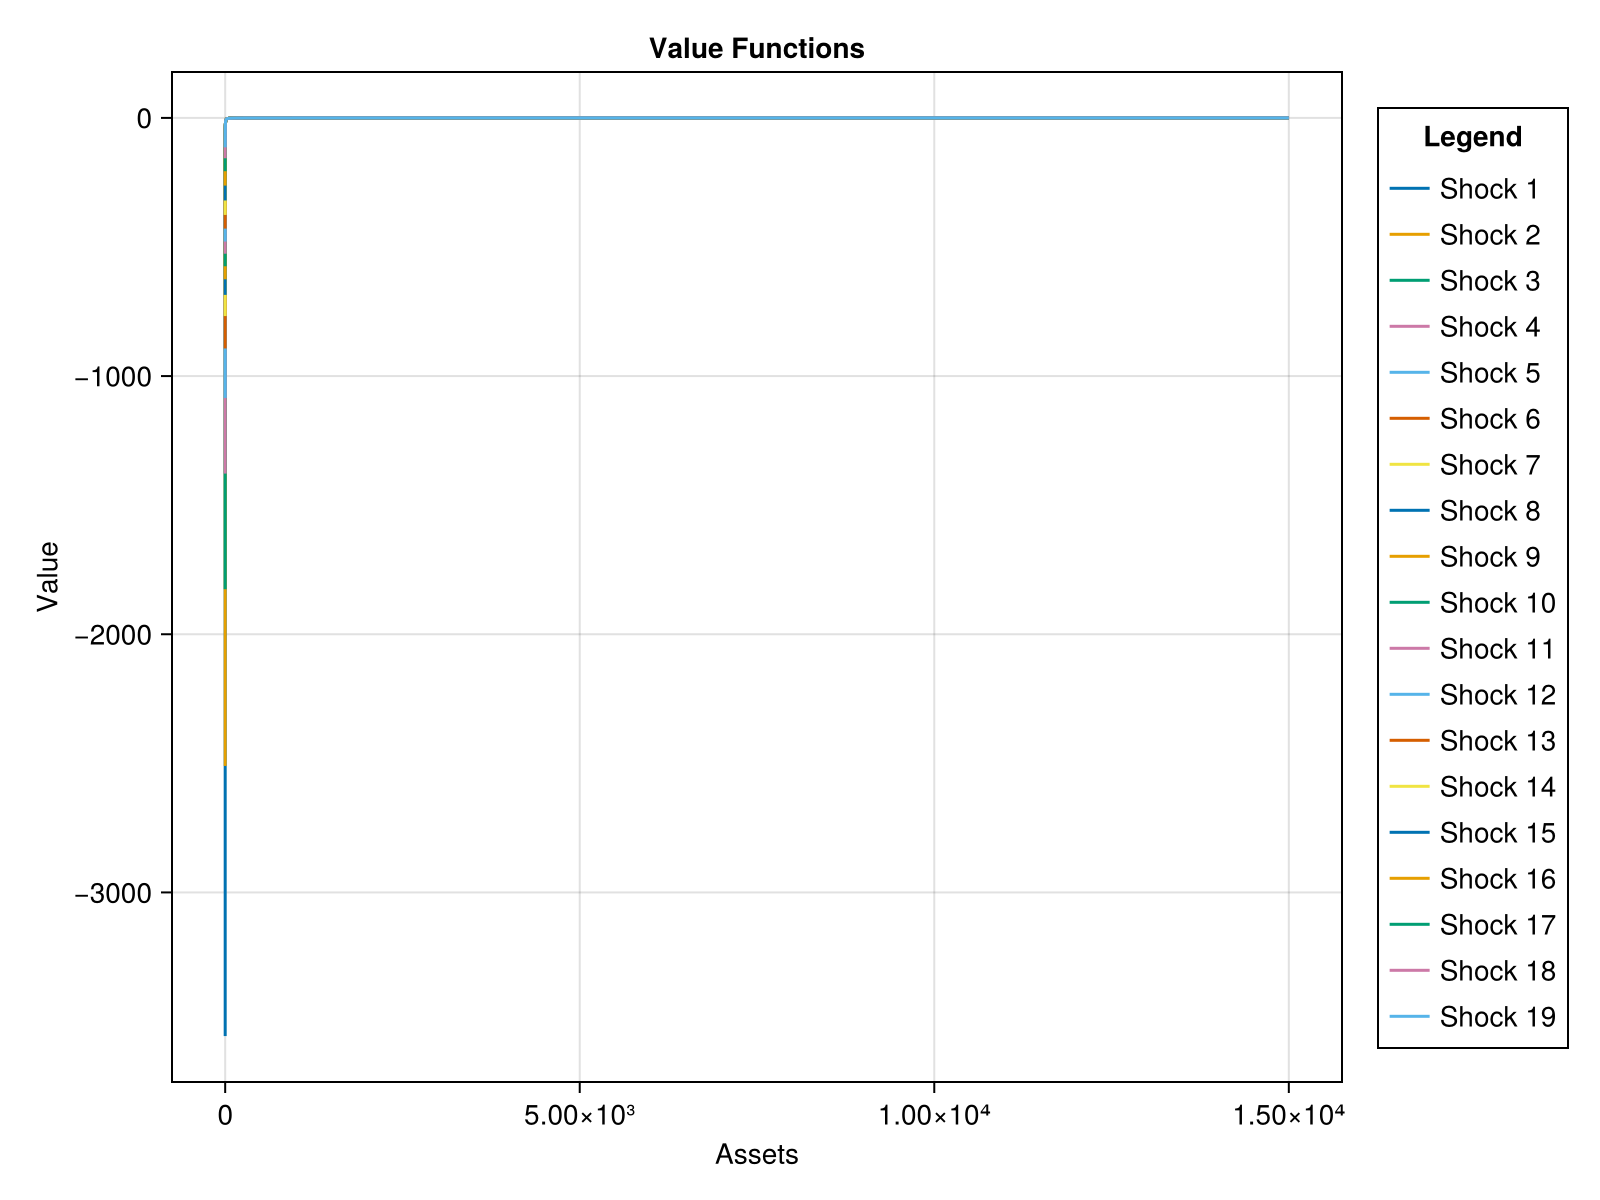

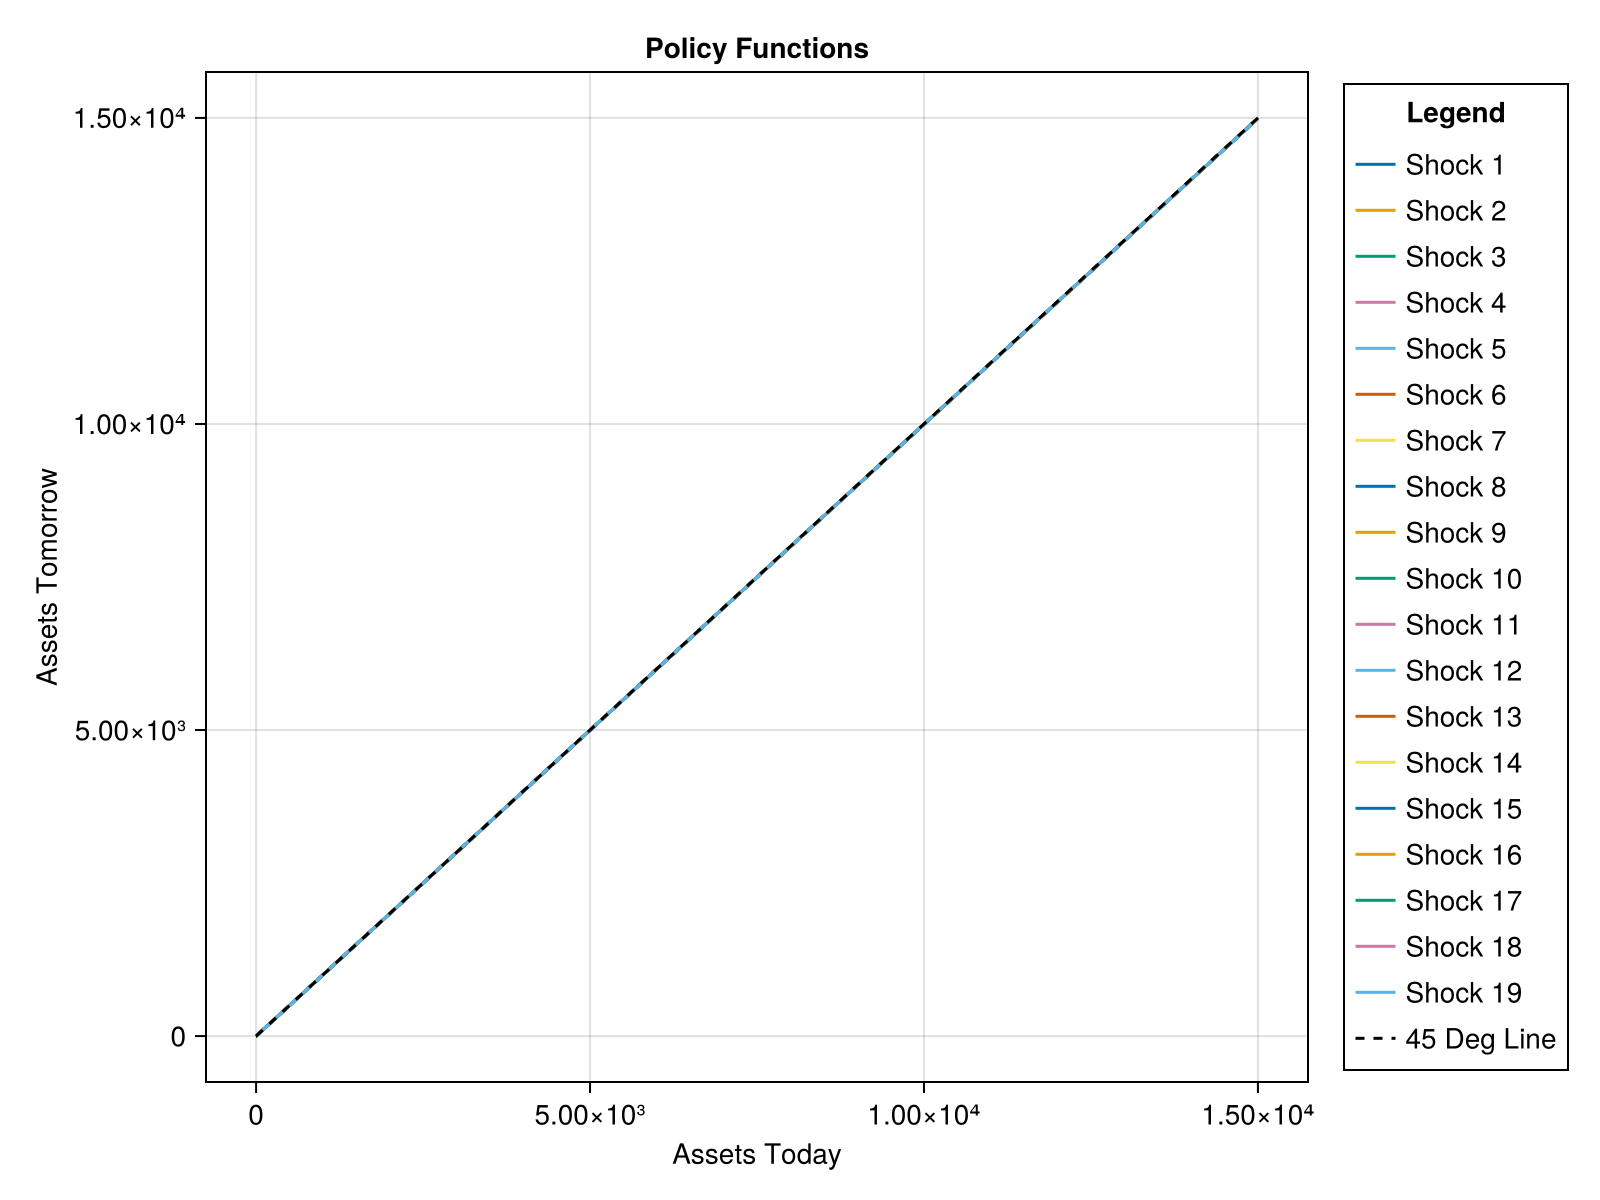

([-3556.484368863616 -2510.159446187564 … -156.2846267364275 -114.08184545134462; -2542.538083517414 -2019.2803938989844 … -156.24380586055344 -114.06045844372119; … ; -0.006307248746544006 -0.006307248677666036 … -0.006307072111974128 -0.006306978701888845; -0.006058661334381402 -0.006058661270808299 … -0.006058498303670867 -0.006058412087550823], [3.0829500473159393e-16 2.801609645960482e-16 … 0.38430790816393895 0.5967801929577115; 2.720136473929327e-16 4.140271117968667e-16 … 0.38445884474089564 0.596930810953213; … ; 14401.659684375043 14401.659841580196 … 14402.062842903879 14402.276055397562; 14992.633665050796 14992.63382226917 … 14993.037467226279 14993.251020393895])

In [4]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)
pol_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

Iterating...
--------------------
Iteration: 0, Error: 3.5510482391475605e-6
--------------------
Converged in 2 iterations
--------------------
  1.009333 seconds (2.94 M allocations: 177.834 MiB, 3.47% gc time, 38.71% compilation time)


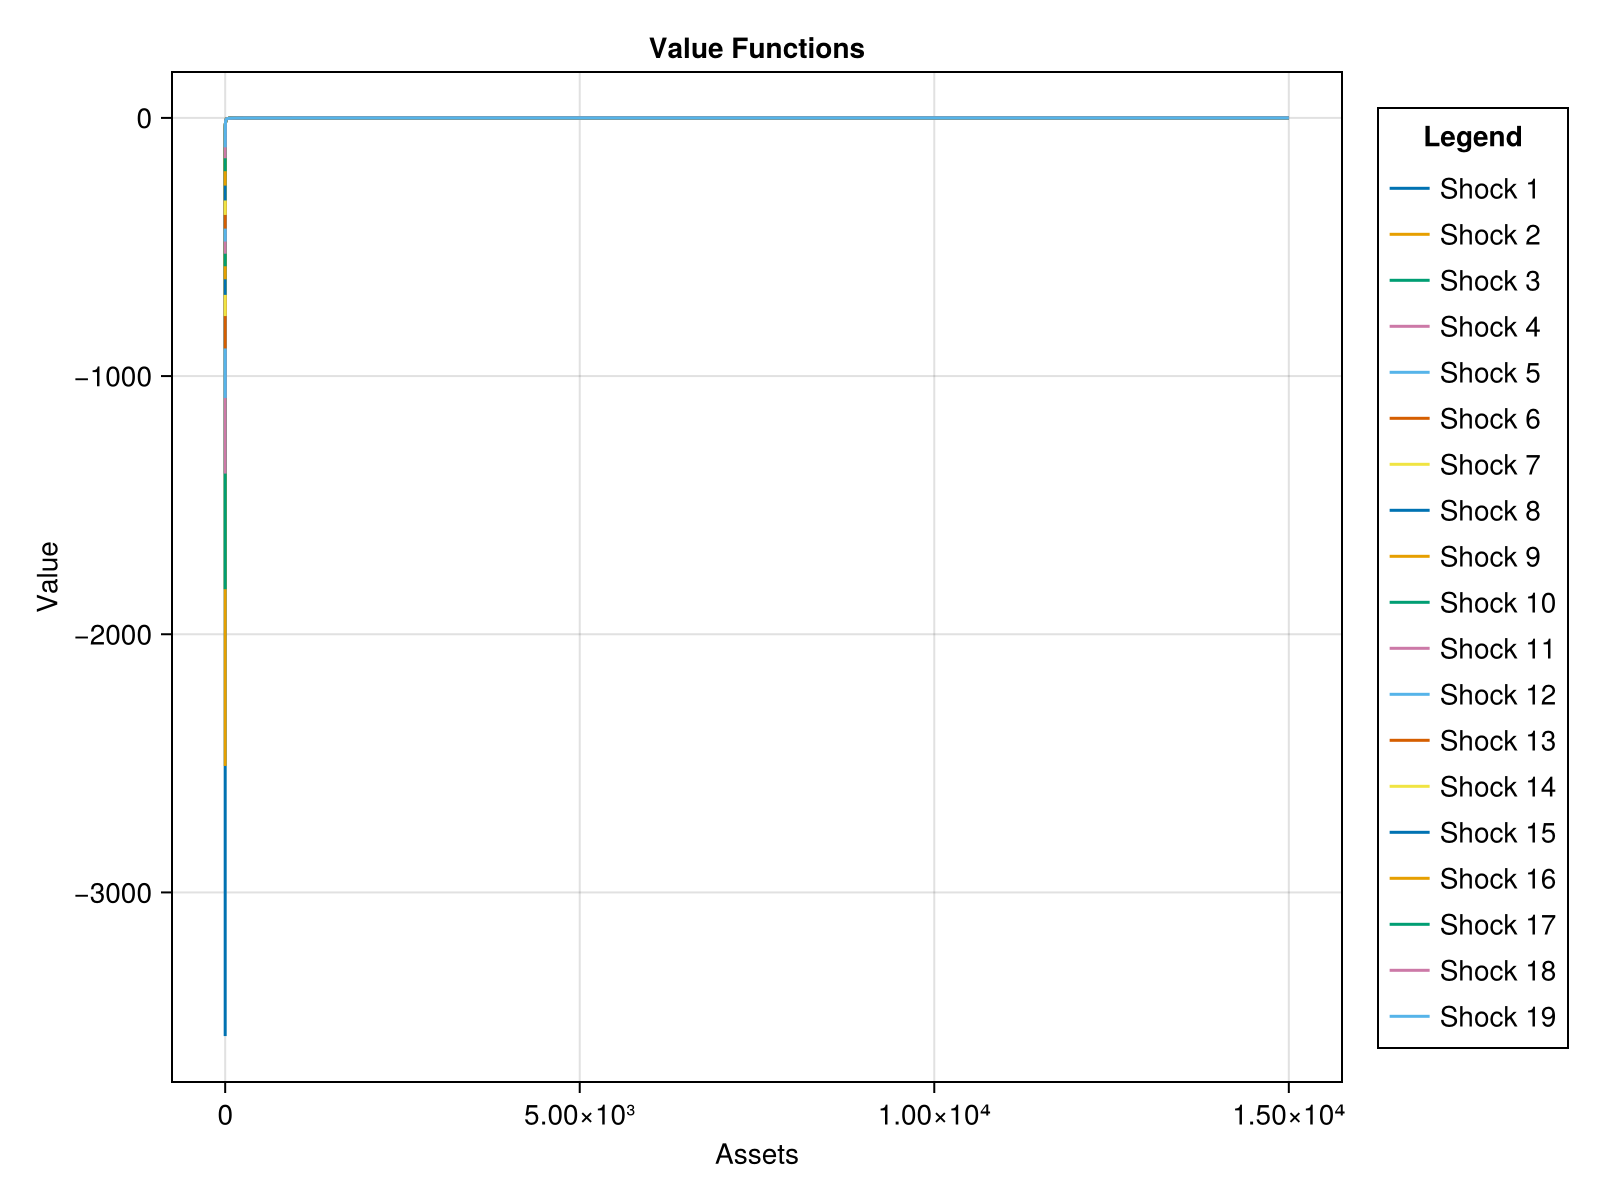

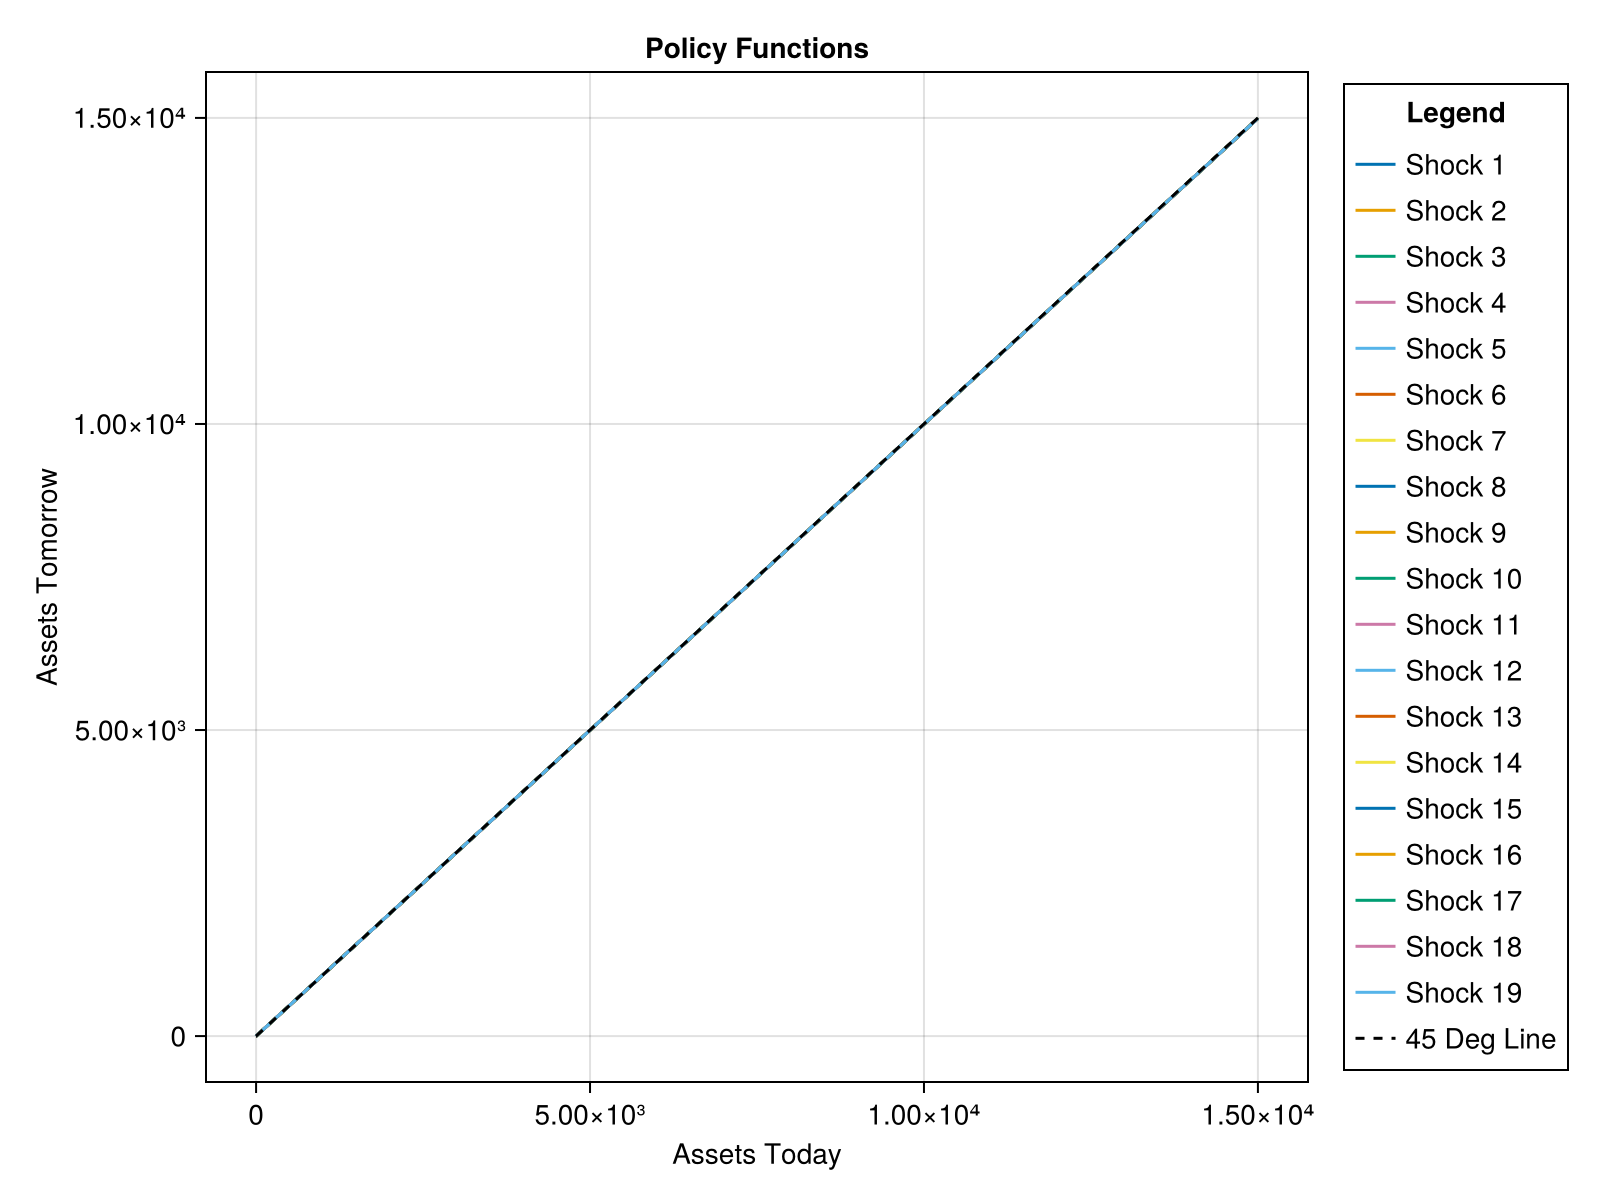

([-3556.484913207729 -2510.159990531677 … -156.2850618963389 -114.08220423953821; -2542.538627861527 -2019.2809382430974 … -156.2442409628082 -114.06081718281243; … ; -0.006308987966781609 -0.006308987897903391 … -0.0063088113315732065 -0.006308717921148734; -0.0060603996409575416 -0.006060399577384201 … -0.0060602366096386175 -0.006060150393195316], [3.0829500473332677e-16 2.801609645998752e-16 … 0.3843079532514404 0.5967802942155569; 2.720136473965797e-16 4.140271118024388e-16 … 0.3844588898559523 0.596930912251798; … ; 14401.662575002485 14401.66273198818 … 14402.065733854244 14402.278946292932; 14992.636771734302 14992.636929191362 … 14993.040573989629 14993.254127380756])

In [5]:
function hpi(v_init, policy, pars)
    (; maxiter, toler, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        v_new = howard(v_new, policy, Π, Avals, Zvals, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end
        
@time begin
    hpi_v, hpi_pol = hpi(v_init, pol_init, pars)
end    

In [8]:
p = (;r = 0.1111111111, # interest rate
    w = 0.00118, # wage   
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion (recall that this must be greater than 1 in the CES formulation)
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 100000000.0) # upper bound of capital grid

(r = 0.1111111111, w = 0.00118, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 1.0e8)

In [2]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=1, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-p.γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, p) - ap, p) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard_CES(v, policy, Π, Agrid, Zgrid, p)
    (; β, na, nz, how_iter, γ) = p
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV_CES(Agrid, exp_val, p)
            for i in 1:na
                obj_CES(ap) = (((1-β) * utility_CES(resources(Agrid, Zgrid, i, j, p) - ap, p) + β * interp_e_val(ap)))^(1/(1-γ))
                v[i,j] = obj_CES(policy[i,j])
            end
        end
    end
    return v
end  

howard_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.9994803624262547
--------------------
Iteration: 100, Error: 0.09966023967302994
--------------------
Iteration: 200, Error: 0.0007769548892458786
--------------------
Converged in 273 iterations
--------------------
  2.883602 seconds (2.63 M allocations: 268.706 MiB, 1.23% gc time, 7.88% compilation time)


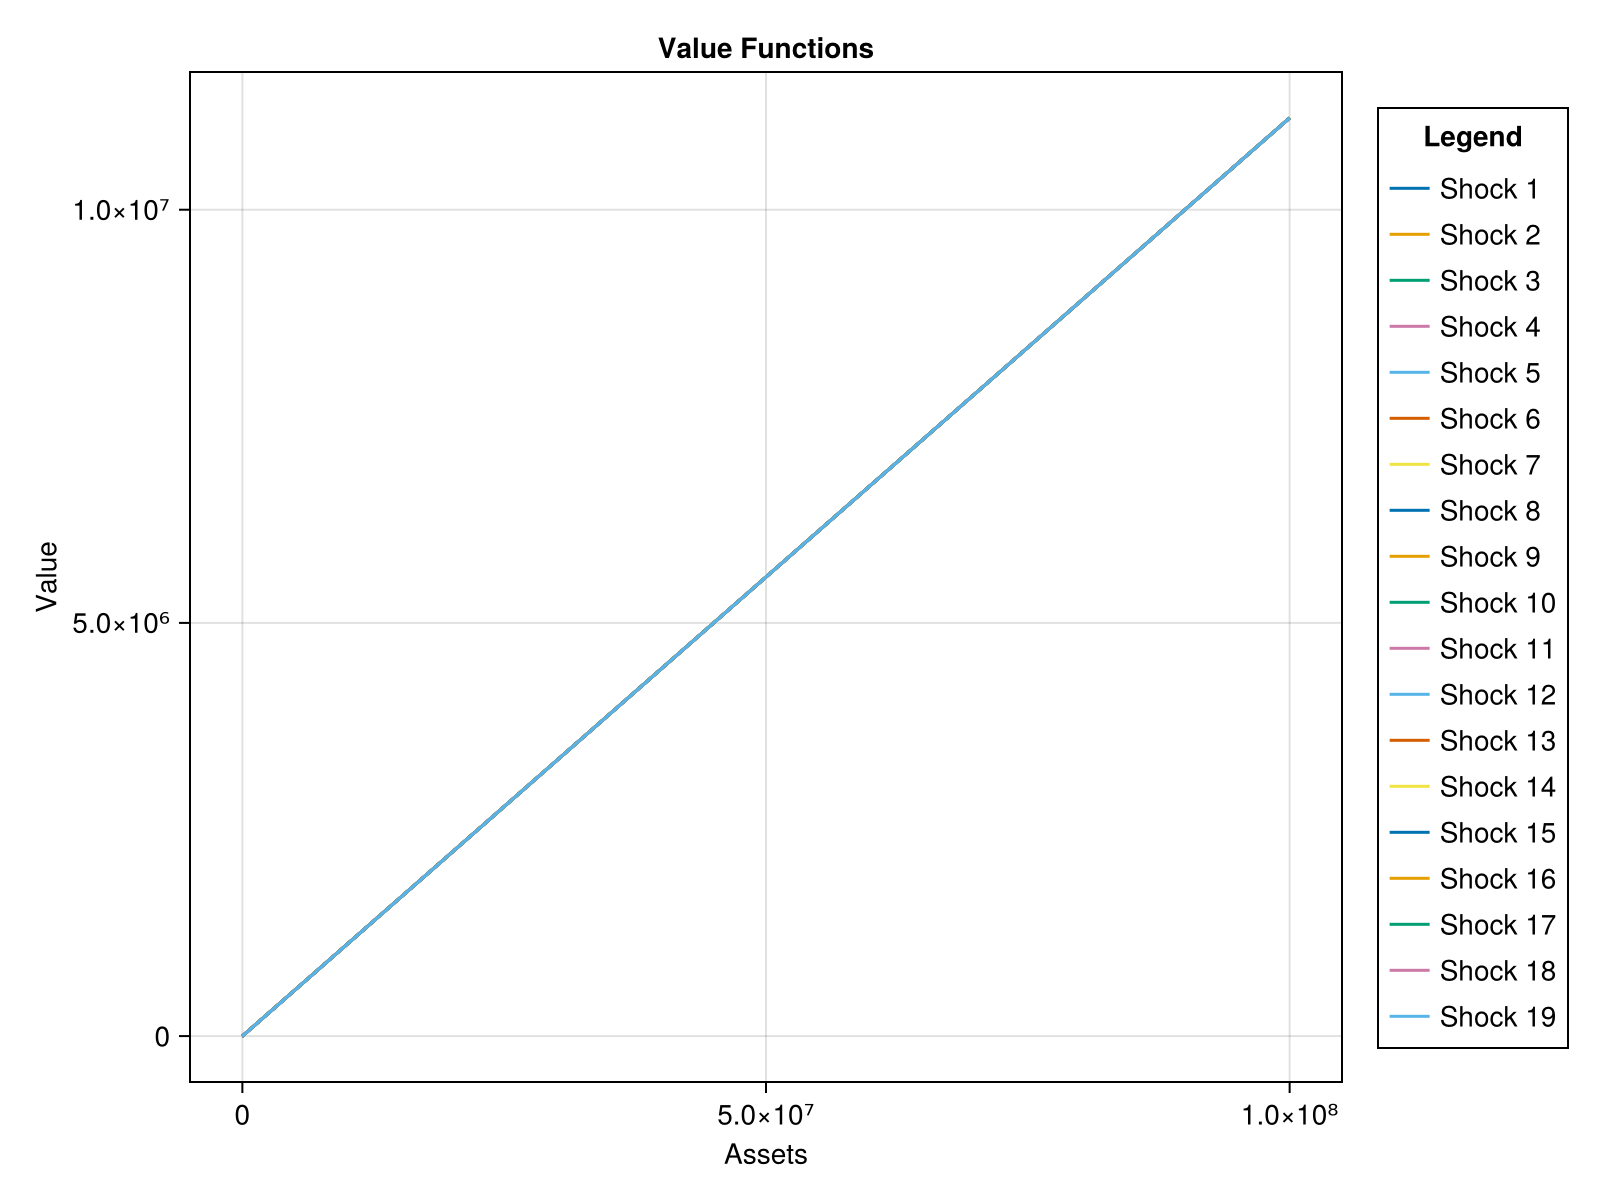

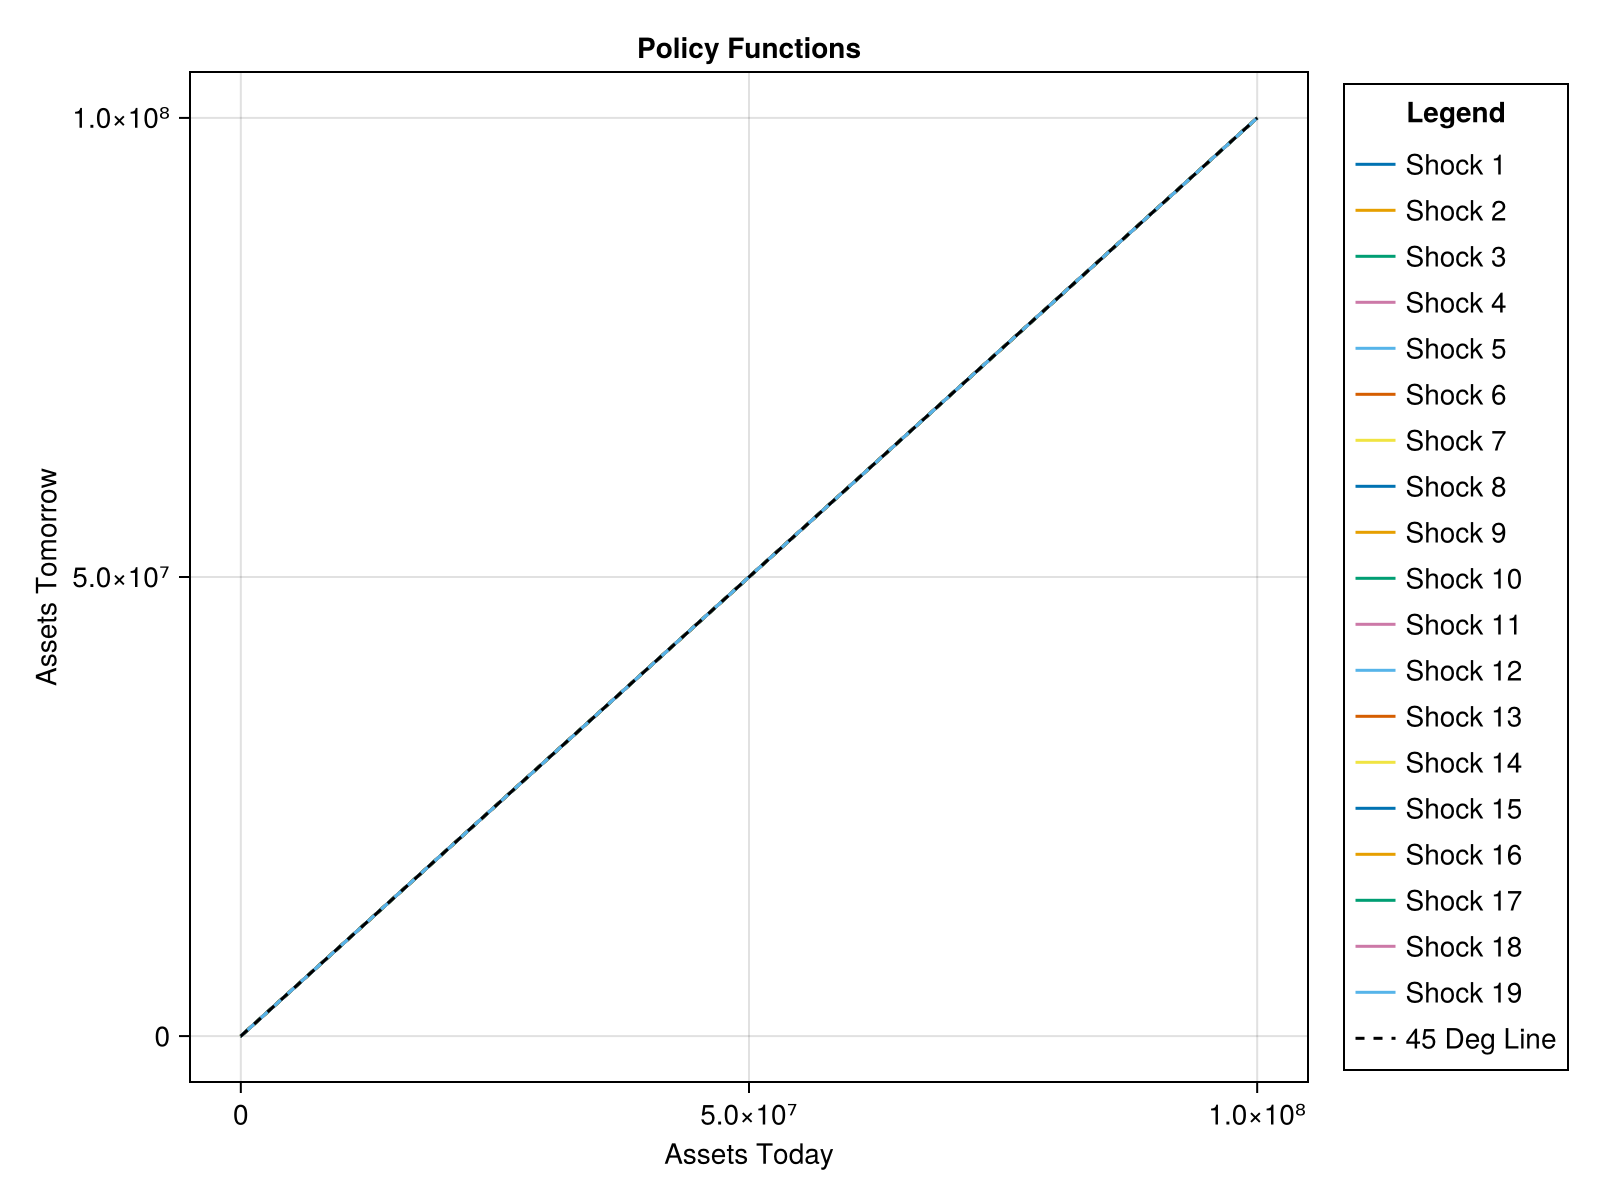

([0.000220019361689613 0.0003110438780743159 … 0.004698976826354422 0.0065693276813342085; 0.11270348518070727 0.11270486422697122 … 0.1162270855688694 0.11809022812847188; … ; 1.0673252289203528e7 1.0673252289204905e7 … 1.0673252292726476e7 1.0673252294589605e7; 1.1111071370891737e7 1.111107137089311e7 … 1.111107137441468e7 1.1111071376277808e7], [3.4879662912265526e-16 3.171968105114183e-16 … 0.030565781547839326 0.047330443844875315; 0.9986510717329122 0.9986634326587512 … 1.0301397843624454 1.0469080475961068; … ; 9.605960081965087e7 9.605960081966825e7 … 9.605960084997302e7 9.605960086673878e7; 1.0000000130234651e8 1.0000000130375399e8 … 1.0000000133684069e8 1.0000000135501671e8])

In [10]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v2 = ones(p.na, p.nz)

@time begin
v_ces, pol_ces = vfi_CES(v2, p)
end

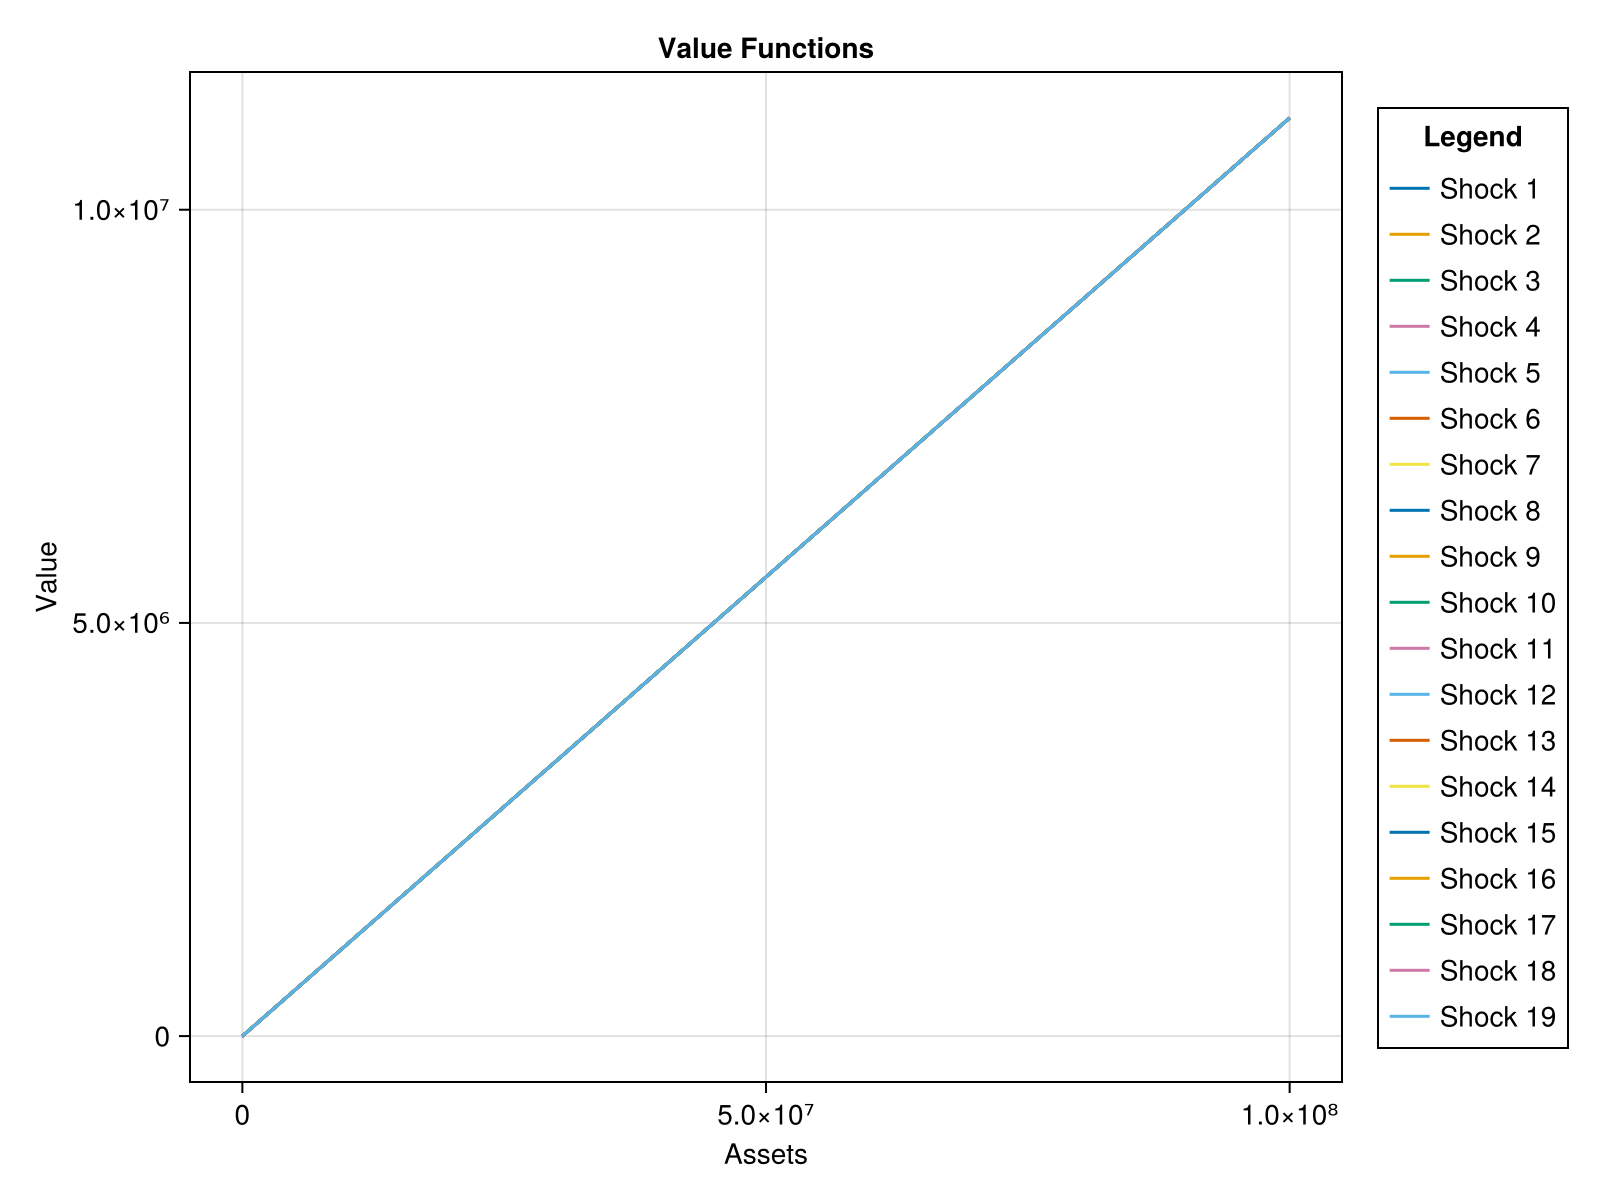

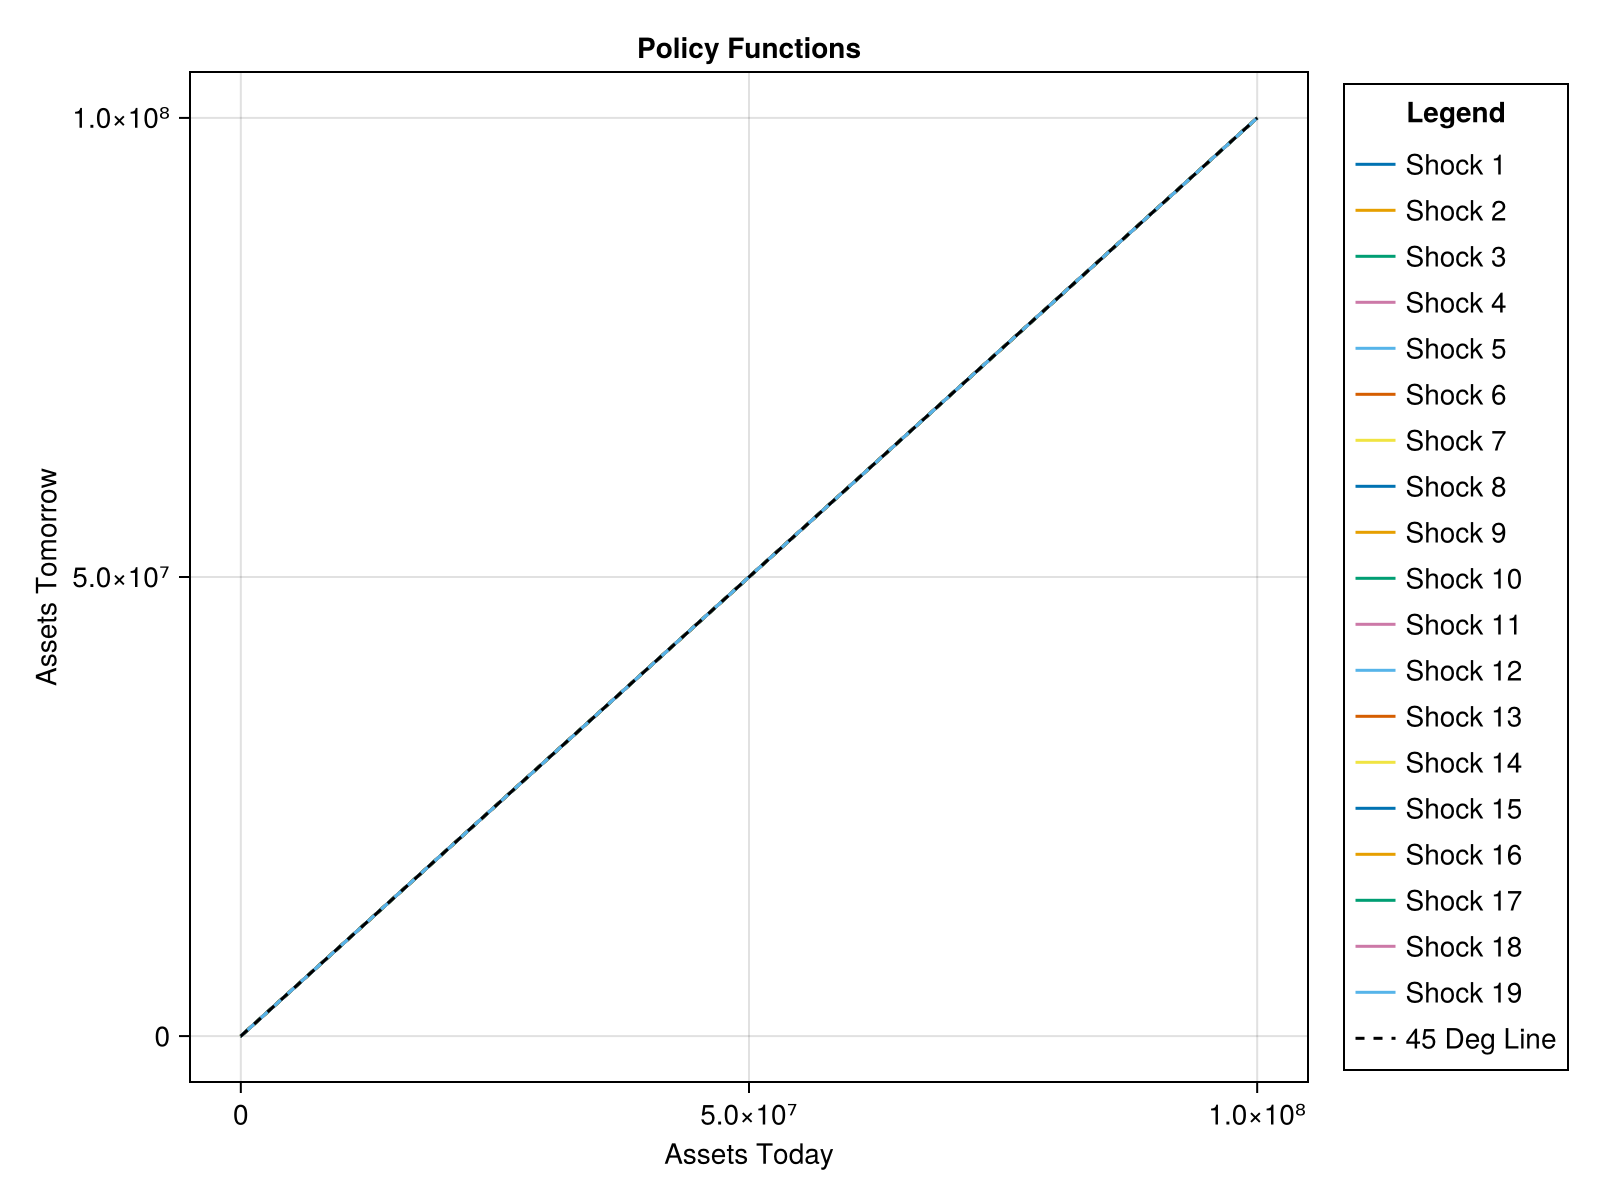

Iterating...
--------------------
Iteration: 0, Error: 3.576356691513116e-6
--------------------
Converged in 2 iterations
--------------------
  0.921170 seconds (1.56 M allocations: 134.162 MiB, 1.70% gc time, 23.06% compilation time)


([0.00022001936168960498 0.0003110438780742998 … 0.004698976826352854 0.006569327681331936; 0.11270348518066486 0.11270486422692876 … 0.11622708556882777 0.11809022812843073; … ; 1.0673289000527173e7 1.0673289000528546e7 … 1.06732890040502e7 1.0673289005913345e7; 1.1111111111594483e7 1.1111111111595858e7 … 1.111111111511752e7 1.1111111116980663e7], [3.4879662912265526e-16 3.171968105114183e-16 … 0.030565781547840072 0.04733044384487708; 0.9986510717488493 0.9986634326429421 … 1.0301397843625293 1.04690804759981; … ; 9.605960099891058e7 9.605960100449882e7 … 9.605960103480186e7 9.605960105157275e7; 1.0000000000073904e8 1.0000000000354382e8 … 1.0000000003663927e8 1.000000000506132e8])

In [11]:
function hpi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        v_new = howard_CES(v_new, policy, Π, Avals, Zvals, p)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

@time begin
    hpi_v_CES, hpi_pol_CES = hpi_CES(v2, p)
end    